### Objetivo:

Criar e testar modelos de machine learning com intuito de prever e identificar as variáveis que mais influenciam para que estudante vá fumar cigarro na adolescência


### Etapas:

1) Carregando tabelas e importando bibliotecas

2) Modelagem (machine learning)
- 2.1) Random Forest com tuning random search
- 2.2) Gradient Boosting com tuning random search
- 2.3) Xgboost

### 1) Carregando tabelas e importando bibliotecas

In [0]:
!pip install pycaret
!pip install shap
import shap
import pycaret
from pycaret.classification import * 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
from sklearn.model_selection import cross_val_score,RandomizedSearchCV,KFold,GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,recall_score,classification_report,roc_curve, auc,confusion_matrix
import xgboost as xgb
from sklearn.inspection import permutation_importance
from sklearn.metrics import f1_score, make_scorer
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Requirement already satisfied: pycaret in /databricks/conda/envs/databricks-ml/lib/python3.7/site-packages (2.2.1)
Requirement already satisfied: lightgbm>=2.3.1 in /databricks/conda/envs/databricks-ml/lib/python3.7/site-packages (from pycaret) (3.1.0)
Requirement already satisfied: nltk in /databricks/conda/envs/databricks-ml/lib/python3.7/site-packages (from pycaret) (3.4.5)
Requirement already satisfied: IPython in /databricks/conda/envs/databricks-ml/lib/python3.7/site-packages (from pycaret) (7.12.0)
Requirement already satisfied: seaborn in /databricks/conda/envs/databricks-ml/lib/python3.7/site-packages (from pycaret) (0.10.0)
Requirement already satisfied: cufflinks>=0.17.0 in /databricks/conda/envs/databricks-ml/lib/python3.7/site-packages (from pycaret) (0.17.3)
Requirement already satisfied: numpy>=1.17 in /databricks/conda/envs/databricks-ml/lib/python3.7/site-packages (from pycaret) (1.18.1)
Requirement already satisfied: scikit-learn>=0.23.2 in /databricks/conda/envs/databricks-ml/lib/python3.7/site-packages (from pycaret) (0.23.2)
Requirement already satisfied: umap-learn in /databricks/conda/envs/databricks-ml/lib/python3.7/site-packages (from pycaret) (0.4.6)
Requirement already satisfied: kmodes>=0.10.1 in /databricks/conda/envs/databricks-ml/lib/python3.7/site-packages (from pycaret) (0.10.2)
Requirement already satisfied: xgboost>=1.1.0 in /databricks/conda/envs/databricks-ml/lib/python3.7/site-packages (from pycaret) (1.2.0)
Requirement already satisfied: catboost>=0.23.2 in /databricks/conda/envs/databricks-ml/lib/python3.7/site-packages (from pycaret) (0.24.3)
Requirement already satisfied: gensim in /databricks/conda/envs/databricks-ml/lib/python3.7/site-packages (from pycaret) (3.8.3)
Requirement already satisfied: wordcloud in /databricks/conda/envs/databricks-ml/lib/python3.7/site-packages (from pycaret) (1.8.1)
Requirement already satisfied: pandas-profiling>=2.8.0 in /databricks/conda/envs/databricks-ml/lib/python3.7/site-packages (from pycaret) (2.9.0)
Requirement already satisfied: pyLDAvis in /databricks/conda/envs/databricks-ml/lib/python3.7/site-packages (from pycaret) (2.1.2)
Requirement already satisfied: textblob in /databricks/conda/envs/databricks-ml/lib/python3.7/site-packages (from pycaret) (0.15.3)
Requirement already satisfied: matplotlib in /databricks/conda/envs/databricks-ml/lib/python3.7/site-packages (from pycaret) (3.1.3)
Requirement already satisfied: mlxtend in /databricks/conda/envs/databricks-ml/lib/python3.7/site-packages (from pycaret) (0.17.3)
Requirement already satisfied: imbalanced-learn>=0.7.0 in /databricks/conda/envs/databricks-ml/lib/python3.7/site-packages (from pycaret) (0.7.0)
Requirement already satisfied: pandas in /databricks/conda/envs/databricks-ml/lib/python3.7/site-packages (from pycaret) (1.0.1)
Requirement already satisfied: mlflow in /databricks/conda/envs/databricks-ml/lib/python3.7/site-packages (from pycaret) (1.11.0)
Requirement already satisfied: pyod in /databricks/conda/envs/databricks-ml/lib/python3.7/site-packages (from pycaret) (0.8.4)
Requirement already satisfied: spacy in /databricks/conda/envs/databricks-ml/lib/python3.7/site-packages (from pycaret) (2.3.2)
Requirement already satisfied: scikit-plot in /databricks/conda/envs/databricks-ml/lib/python3.7/site-packages (from pycaret) (0.3.7)
Requirement already satisfied: plotly>=4.4.1 in /databricks/conda/envs/databricks-ml/lib/python3.7/site-packages (from pycaret) (4.10.0)
Requirement already satisfied: joblib in /databricks/conda/envs/databricks-ml/lib/python3.7/site-packages (from pycaret) (0.14.1)
Requirement already satisfied: yellowbrick>=1.0.1 in /databricks/conda/envs/databricks-ml/lib/python3.7/site-packages (from pycaret) (1.2)
Requirement already satisfied: ipywidgets in /databricks/conda/envs/databricks-ml/lib/python3.7/site-packages (from pycaret) (7.5.1)
Requirement already satisfied: scipy in /databricks/conda/envs/databricks-ml/lib/python3.7/sit

In [0]:
abt_treino = spark.sql("select * from abt_treino_fs")
abt_teste = spark.sql("select * from abt_teste_fs")

abt_treino = abt_treino.toPandas()
abt_teste = abt_teste.toPandas()

y_train = abt_treino[['ja_fumou']]
y_test = abt_teste[['ja_fumou']]
x_train= abt_treino.drop(columns=['ja_fumou'],axis=1)
x_test= abt_teste.drop(columns=['ja_fumou'],axis=1)

### 2) Modelagem com machine learning

In [0]:
rf_grid_dc = {
    'n_estimators': [50,100,200],
    'max_depth':[3,4]
}

rf_grid =RandomForestClassifier(random_state=42)
rf_randomized = RandomizedSearchCV (rf_grid,
                       rf_grid_dc,
                       cv=10)

rf_randomized.fit(x_train,y_train)

p = rf_randomized.predict(x_test) 


recall_rf = recall_score(y_test,p)


print(('Recall',recall_rf))

print('best_params:',rf_randomized.best_params_)

('Recall', 0.1432695777697582)
best_params: {'n_estimators': 200, 'max_depth': 4}

In [0]:
dict = classification_report(y_test['ja_fumou'],p, output_dict=True)
pd.DataFrame(dict)

Out[14]:

,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.847123,0.763662,0.843283,0.805393,0.832018
recall,0.986722,0.194154,0.843283,0.590438,0.843283
f1-score,0.911609,0.309596,0.843283,0.610602,0.802656
support,25080.000000,5542.000000,0.843283,30622.000000,30622.000000


Out[5]:

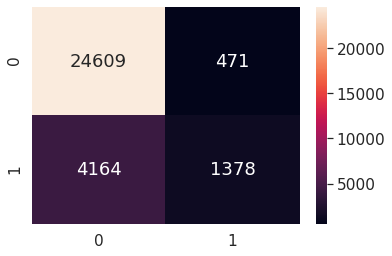

<matplotlib.axes._subplots.AxesSubplot at 0x7f90a4b7a710>

In [0]:
cm = confusion_matrix(y_test['ja_fumou'],p)

sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, annot_kws={"size": 18}, fmt='g')

In [0]:

importancia = pd.DataFrame(OrderedDict({'Variaveis':x_train.columns,
                                        'Importancia':rf_randomized.best_estimator_.feature_importances_}))
importancia = importancia.sort_values(by='Importancia', ascending=False)
importancia.head(15)

Out[6]:

,Variaveis,Importancia
6,ja_usou_droga,0.171835
7,ja_bebeu,0.161750
9,Ja_Teve_Relacao_Sexual,0.129656
8,doses_ultimo_mes30dias,0.079577
22,qtd_amigos_que_drogasNenhum,0.074369
1,qtd_embriaguez_na_vida1ou2vezesnavida,0.065530
0,qtd_embriaguez_na_vida3a5vezesnavida,0.044814
20,qtd_brigas_por_bebidaNenhumaveznavida0vez,0.041308
4,qtd_amigos_que_drogasAmaioria,0.038059
2,qtd_embriaguez_na_vida10oumaisvezesnavida,0.036007


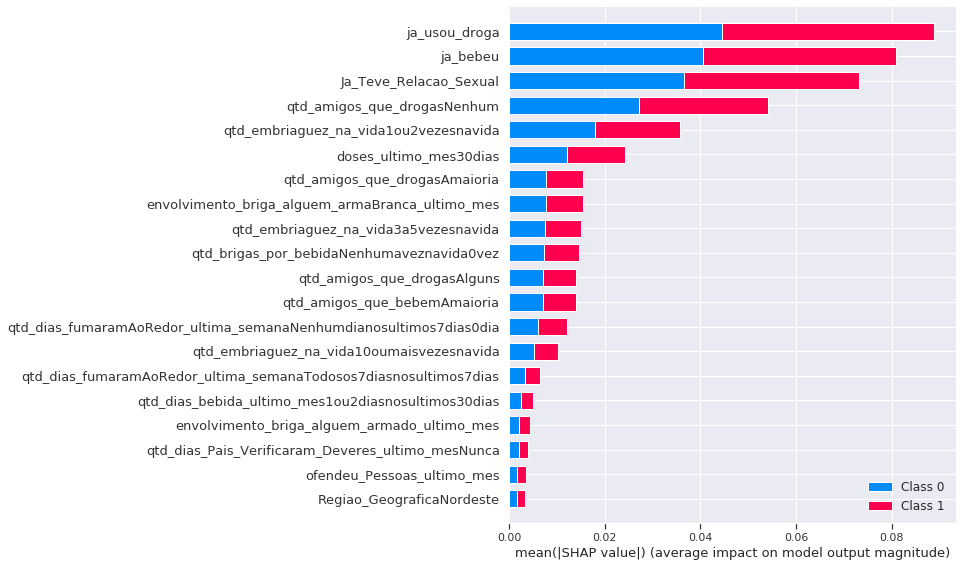

In [0]:
explainer = shap.TreeExplainer(rf_randomized.best_estimator_)
shap_values = explainer.shap_values(x_test)
shap.summary_plot(shap_values, x_test)

In [0]:
#Dicionario
gb_grid_dc = {
    'n_estimators': [50,100],
    'subsample': [0.6,0.8],
    'max_features':[5,7,9],
    'max_depth':[4,5,6]
}


gb_grid = GradientBoostingClassifier(random_state=42)
gb_randomized = RandomizedSearchCV (gb_grid,
                       gb_grid_dc,
                       cv=4)

gb_randomized.fit(x_train,y_train)

p2 = gb_randomized.predict(x_test) 

recall_gb = recall_score(y_test,p2)

print(('Recall',recall_gb))

print('best_params:',gb_randomized.best_params_)

('Recall', 0.4402742692168892)
best_params: {'subsample': 0.6, 'n_estimators': 100, 'max_features': 5, 'max_depth': 5}

In [0]:
dict = classification_report(y_test['ja_fumou'],p2, output_dict=True)
pd.DataFrame(dict)

Out[9]:

,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.885069,0.671806,0.859774,0.778437,0.846472
recall,0.952472,0.440274,0.859774,0.696373,0.859774
f1-score,0.917534,0.531938,0.859774,0.724736,0.847749
support,25080.000000,5542.000000,0.859774,30622.000000,30622.000000


Out[10]:

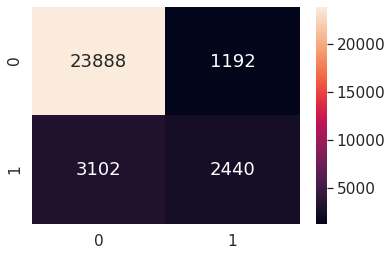

<matplotlib.axes._subplots.AxesSubplot at 0x7f90a415ac10>

In [0]:
cm = confusion_matrix(y_test['ja_fumou'],p2)

sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, annot_kws={"size": 18}, fmt='g')

In [0]:

importancia = pd.DataFrame(OrderedDict({'Variaveis':x_train.columns,
                                        'Importancia':gb_randomized.best_estimator_.feature_importances_}))
importancia = importancia.sort_values(by='Importancia', ascending=False)
importancia.head(15)

Out[11]:

,Variaveis,Importancia
7,ja_bebeu,0.169480
9,Ja_Teve_Relacao_Sexual,0.128490
6,ja_usou_droga,0.086184
22,qtd_amigos_que_drogasNenhum,0.065664
8,doses_ultimo_mes30dias,0.065303
1,qtd_embriaguez_na_vida1ou2vezesnavida,0.060663
0,qtd_embriaguez_na_vida3a5vezesnavida,0.055843
2,qtd_embriaguez_na_vida10oumaisvezesnavida,0.040942
4,qtd_amigos_que_drogasAmaioria,0.037290
20,qtd_brigas_por_bebidaNenhumaveznavida0vez,0.032512


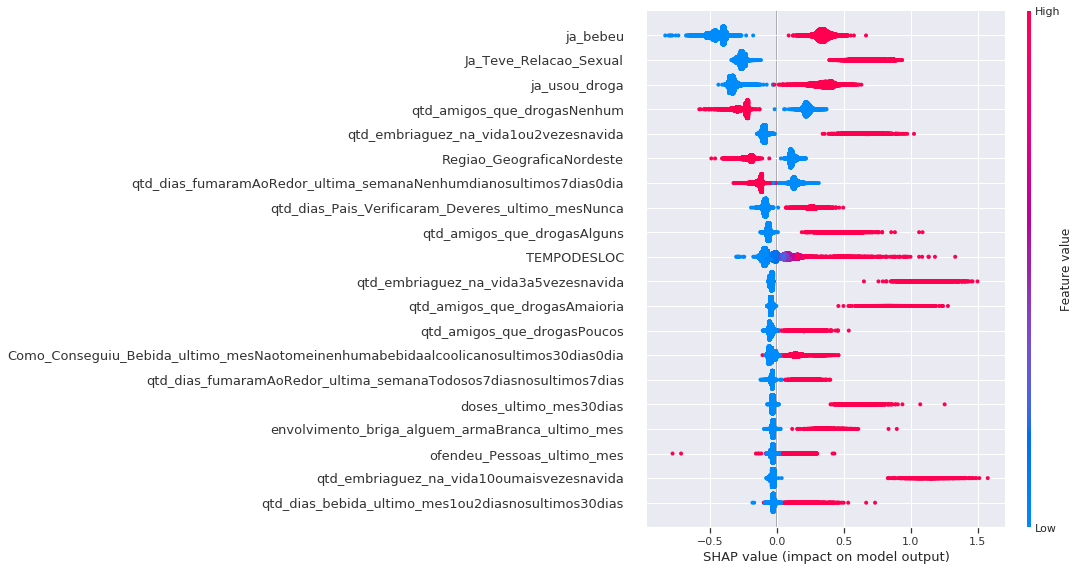

In [0]:
explainer = shap.TreeExplainer(gb_randomized.best_estimator_)
shap_values = explainer.shap_values(x_test)
shap.summary_plot(shap_values, x_test)

In [0]:
parameters = {
              'min_samples_leaf' :[0.5,0.9],
              'colsample_bytree' :[0.8,0.9]
              }

xgboost = xgb.XGBClassifier(objective ='reg:logistic' ,random_state=42,n_estimators=50,max_depth = 6)
grid_search2 = GridSearchCV(xgboost, parameters, cv=3,n_jobs=-1)
grid_search2.fit(x_train,y_train)

p3 = grid_search2.best_estimator_.predict(x_test) 

recall_xgboost = recall_score(y_test,p3)

print(('Recall',recall_xgboost))

print('best_params:',(grid_search2.best_params_))

[01:16:29] WARNING: ../src/learner.cc:516: 
Parameters: { min_samples_leaf } might not be used.

 This may not be accurate due to some parameters are only used in language bindings but
 passed down to XGBoost core. Or some parameters are not used but slip through this
 verification. Please open an issue if you find above cases.


('Recall', 0.4361241429086972)
best_params: {'colsample_bytree': 0.9, 'min_samples_leaf': 0.5}

In [0]:
dict = classification_report(y_test['ja_fumou'],p3, output_dict=True)
pd.DataFrame(dict)

Out[4]:

,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.884178,0.663829,0.857978,0.774003,0.844299
recall,0.951196,0.436124,0.857978,0.693660,0.857978
f1-score,0.916463,0.526407,0.857978,0.721435,0.845871
support,25080.000000,5542.000000,0.857978,30622.000000,30622.000000


Out[5]:

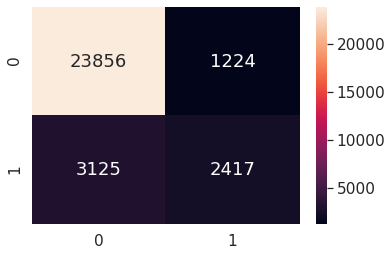

<matplotlib.axes._subplots.AxesSubplot at 0x7eff6c561850>

In [0]:
cm = confusion_matrix(y_test['ja_fumou'],p3)

sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, annot_kws={"size": 18}, fmt='g')

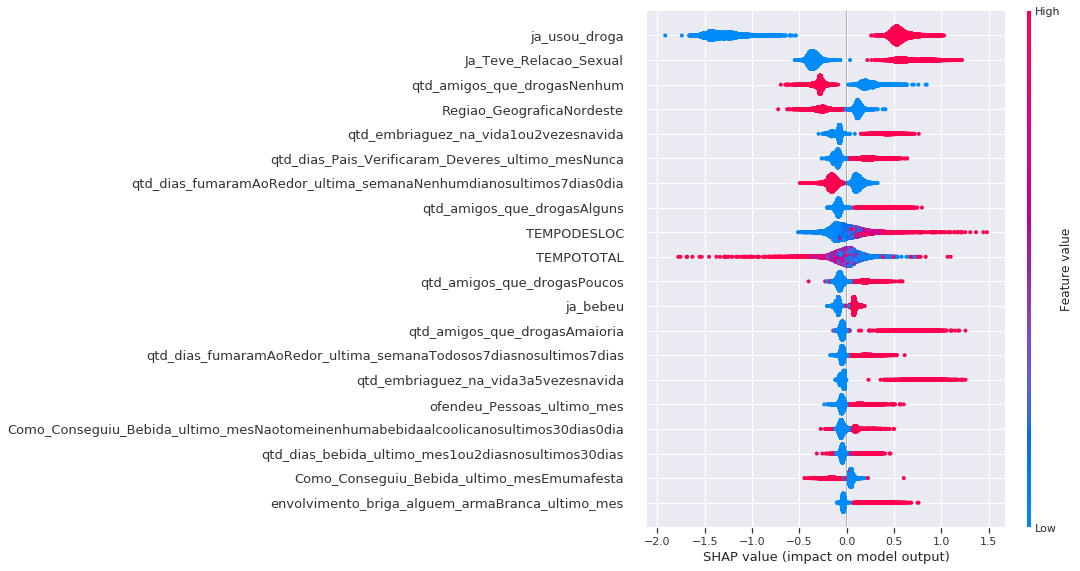

In [0]:
explainer = shap.TreeExplainer(grid_search2.best_estimator_)
shap_values = explainer.shap_values(x_test)
shap.summary_plot(shap_values, x_test)

In [0]:

importancia = pd.DataFrame(OrderedDict({'Variaveis':x_train.columns,
                                        'Importancia':grid_search2.best_estimator_.feature_importances_}))
importancia = importancia.sort_values(by='Importancia', ascending=False)
importancia.head(15)

Out[7]:

,Variaveis,Importancia
7,ja_bebeu,0.471371
6,ja_usou_droga,0.286580
9,Ja_Teve_Relacao_Sexual,0.048033
22,qtd_amigos_que_drogasNenhum,0.027657
0,qtd_embriaguez_na_vida3a5vezesnavida,0.018699
2,qtd_embriaguez_na_vida10oumaisvezesnavida,0.015175
4,qtd_amigos_que_drogasAmaioria,0.013171
1,qtd_embriaguez_na_vida1ou2vezesnavida,0.013116
8,doses_ultimo_mes30dias,0.012603
5,qtd_amigos_que_drogasAlguns,0.009750


In [0]:
comparando = pd.DataFrame({'Random Forest':recall_score(y_test['ja_fumou'],rf_randomized.predict(x_test)),
                            'Gradient Boosting':recall_score(y_test['ja_fumou'],gb_randomized.predict(x_test)),
                            'Xgboost':recall_score(y_test['ja_fumou'],grid_search2.best_estimator_.predict(x_test))},index=[0])
comparando = comparando.transpose()
comparando

Out[16]:

,0
Random Forest,0.254962
Gradient Boosting,0.439733
Xgboost,0.436124


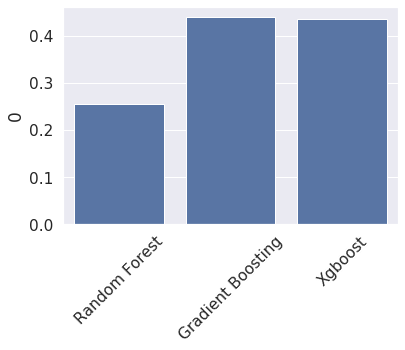

In [0]:
sns.barplot(x=comparando.index,y=0, data=comparando, color="b")
plt.xticks(rotation=45)
plt.show()